In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ghibtools as gh
import pandas as pd
from params import *

In [2]:
subject = 'S1'

# SPINDLES

In [3]:
signal = xr.open_dataarray(f'../preproc/{subject}_reref.nc')
morlet = xr.open_dataarray(f'../sigma/{subject}_morlet_sigma.nc')
hilbert = xr.open_dataarray(f'../sigma/{subject}_hilbert_sigma.nc')

In [8]:
spindles = pd.read_excel(f'../event_detection/{subject}_spindles_reref_human.xlsx', index_col = 0)

In [9]:
signal_eeg = signal.sel(chan = eeg_chans)

In [61]:
t = 9166
wsize = 2
start = t - wsize
stop = t + wsize

In [62]:
signal_sliced = signal_eeg.sel(time = slice(start, stop))
morlet_sliced = morlet.sel(time = slice(start,stop))
hilbert_sliced = hilbert.sel(time = slice(start,stop))

In [63]:
time = hilbert_sliced.coords['time']
freqs = morlet_sliced.coords['freq']

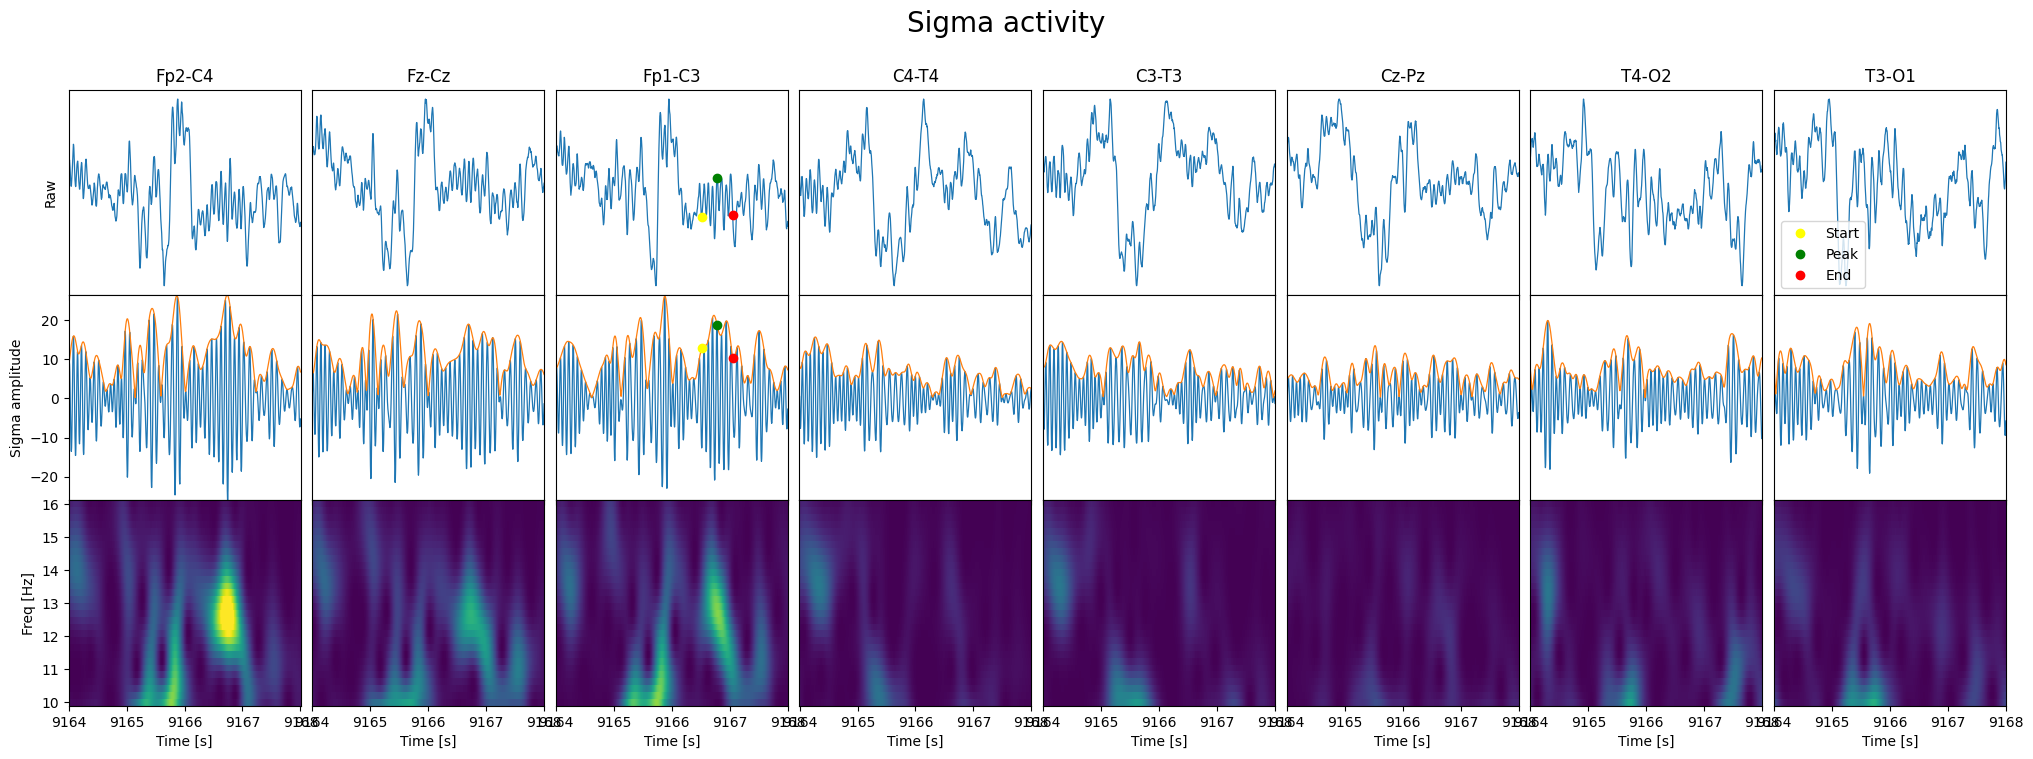

In [64]:
fig, axs = plt.subplots(nrows = 3, ncols = len(eeg_mono_chans), figsize = (25,8), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.05)
fig.suptitle('Sigma activity', fontsize =  20)

lw = 0.9

vmin_morlet = morlet_sliced.quantile(0.001)
vmax_morlet = morlet_sliced.quantile(0.999)
vmin_hilbert = hilbert_sliced.min()
vmax_hilbert = hilbert_sliced.max()

for col, channel in enumerate(eeg_mono_chans):
    
    markers = ['Start','Peak','End']
    colors_markers = ['yellow','green','red']
    
    peak_timings = {}
    for marker in markers:
        mask = (spindles[marker] > start) & (spindles[marker] < stop)  & (spindles['Channel'] == channel)
        peak_timings[marker] = spindles[mask][marker]
    
    signal_chan = signal_sliced.sel(chan=channel)
    morlet_sliced_chan = morlet_sliced.sel(chan=channel)
    hilbert_sliced_chan = hilbert_sliced.sel(chan=channel)
    
    ax = axs[0, col]
    ax.plot(time, signal_chan, linewidth=lw)
    for marker, color in zip(markers, colors_markers):
        ax.plot(peak_timings[marker], signal_chan[np.isin(time, peak_timings[marker])], 'o', label = marker, color = color)
        
    if col == len(eeg_chans) -1:
        ax.legend()
    ax.set_title(channel)
    if col == 0:
        ax.set_ylabel('Raw')
    ax.set_yticks([])

    ax = axs[1, col]
    ax.plot(time, hilbert_sliced_chan.loc['filtered',:] , linewidth=lw)
    ax.plot(time, hilbert_sliced_chan.loc['envelope',:] , linewidth=lw)
    for marker, color in zip(markers, colors_markers):
        ax.plot(peak_timings[marker], hilbert_sliced_chan.loc['envelope',:][np.isin(time, peak_timings[marker])], 'o', label = marker, color = color)
    ax.set_ylim(vmin_hilbert, vmax_hilbert)
    if col == 0:
        ax.set_ylabel('Sigma amplitude')
    if col !=0:
        ax.set_yticks([])

    ax = axs[2, col]
    data = morlet_sliced_chan.values
    ax.pcolormesh(time, freqs , data, vmin = vmin_morlet, vmax = vmax_morlet)
    if col == 0:
        ax.set_ylabel('Freq [Hz]')
    ax.set_xlabel('Time [s]')
    if col !=0:
        ax.set_yticks([])

# SLOW-WAVES

In [20]:
sw = pd.read_excel(f'../event_detection/{subject}_slowwaves_reref_human.xlsx', index_col = 0)

In [11]:
signal_slowwave = signal_eeg.copy()
signal_slowwave_filtered = np.array([gh.filter_sig(signal_eeg.loc[chan , :].values , srate, 0.3 , 1.5) for chan in eeg_chans])
signal_slowwave.loc[:,:] = signal_slowwave_filtered

In [12]:
t = 4583
wsize = 3
start = t - wsize
stop = t + wsize

In [13]:
signal_sliced = signal_eeg.sel(time = slice(start, stop))
signal_sw_sliced = signal_slowwave.sel(time = slice(start,stop))

In [14]:
time = signal_sliced.coords['time']

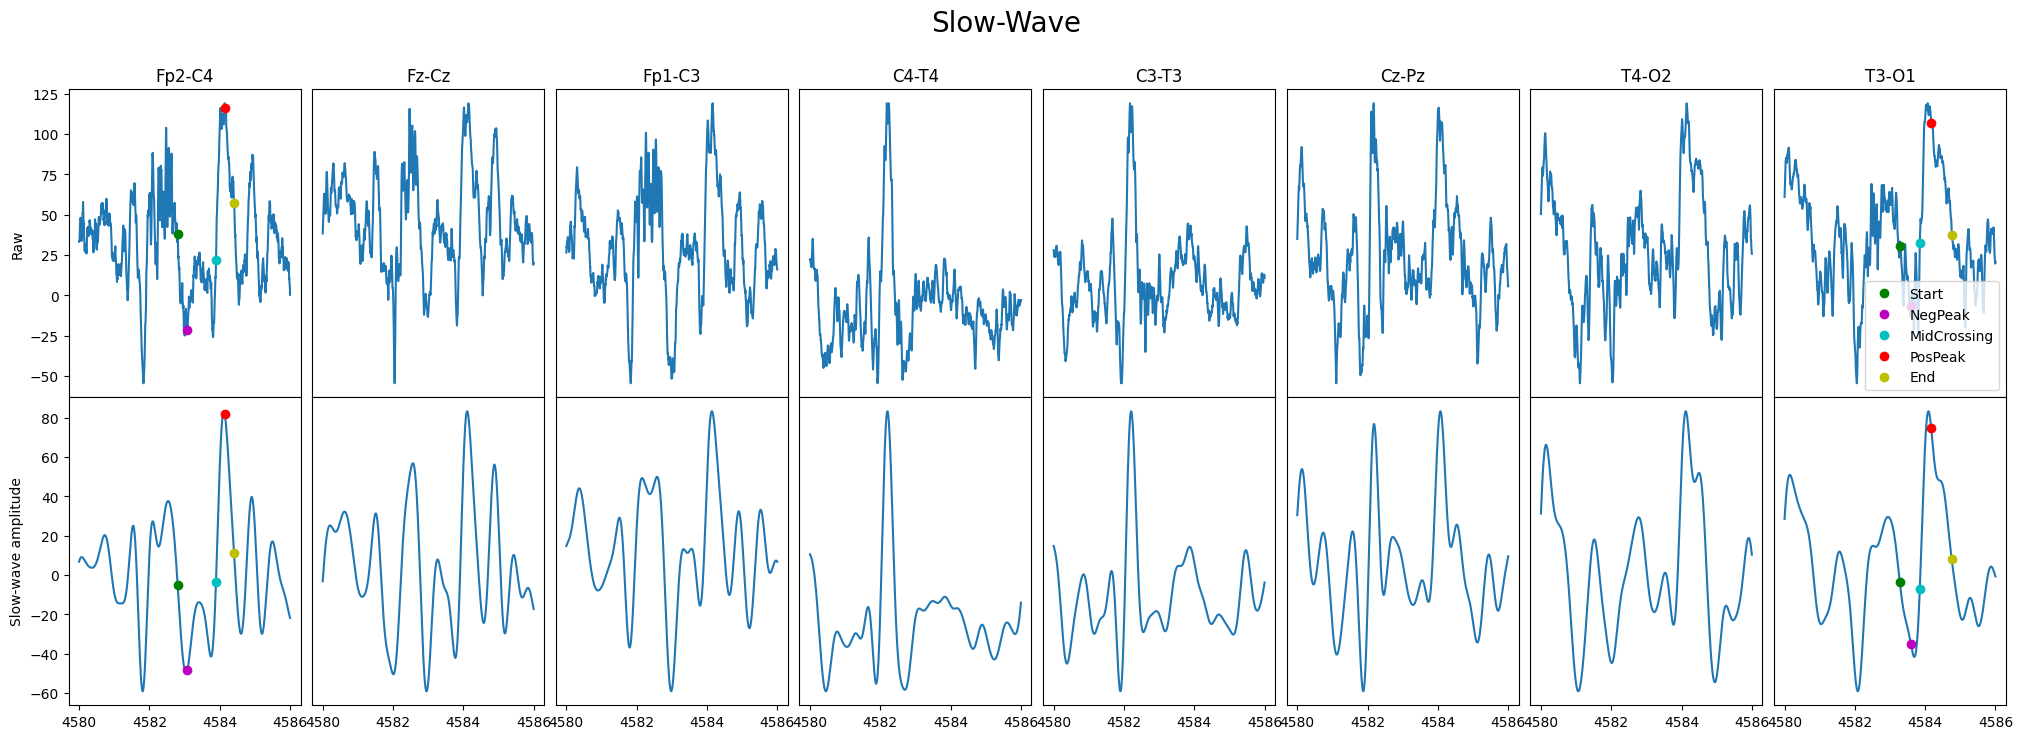

In [15]:
fig, axs = plt.subplots(nrows = 2, ncols = len(eeg_mono_chans), figsize = (25,8), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.05)
fig.suptitle('Slow-Wave', fontsize =  20)

markers = {'Start':'g','NegPeak':'m','MidCrossing':'c','PosPeak':'r','End':'y'}
for col, channel in enumerate(eeg_mono_chans):

    peak_timings = {}
    for marker in markers.keys():
        mask = (sw[marker] > start) & (sw[marker] < stop)  & (sw['Channel'] == channel)
        peak_timings[marker] = sw[mask][marker]
    
    signal_chan = signal_sliced.sel(chan=channel)
    signal_slowwave_chan = signal_sw_sliced.sel(chan=channel)
    
    ax = axs[0, col]
    ax.plot(time, signal_chan)
    for marker in markers.keys():
        ax.plot(peak_timings[marker], signal_chan[np.isin(time, peak_timings[marker])], 'o', label = marker, color = markers[marker])
        
    if col == len(eeg_chans) - 1:
        ax.legend()
    ax.set_title(channel)
    if col == 0:
        ax.set_ylabel('Raw')
    if col != 0:
        ax.set_yticks([])

    ax = axs[1, col]
    ax.plot(time, signal_slowwave_chan)
    for marker in markers.keys():
        ax.plot(peak_timings[marker], signal_slowwave_chan[np.isin(time, peak_timings[marker])], 'o', label = marker, color = markers[marker])
    
    if col == 0:
        ax.set_ylabel('Slow-wave amplitude')
    if col !=0:
        ax.set_yticks([])